--- NOTES ---

- 1 ns unit for time
- Convention: [qubit, resonator 1, resonator 2]

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import plots
from supports_1q_2c import *
from qutip import *
from scipy.special import erf
from scipy.signal import argrelextrema

pi = np.pi
exp = np.exp
sqrt = np.sqrt
hbar = 1.0546e-34*1e-9  # reduced Planck constant
All = 'all'
options = Options()

In [23]:
Nq = 3   # number of levels in qubit
N1 = 10  # number of levels in resonator 1
N2 = 10  # number of levels in resonator 2

wq = 7*2*pi  # qubit frequency
wp = wq  # pump frequency
w1 = wq  # resonator 1 frequency
w2 = wq  # resonator 2 frequency

kq = 50e-6*2*pi  # photon emission frequency of qubit (qubit decay rate)
k1 = 10e-6*2*pi  # photon emission freqency of resonator 1 (resonator 1 decay rate)
k2 = 8e-3*2*pi   # photon emission frequency of resonator 2 (resonator 2 decay rate)

g1 = 400e-6*2*pi  # drive frequency resonator 1, coupling between qubit and resonator 1
g2 = 3e-3*2*pi    # drive frequency resonator 2, coupling between qubit and resonator 2

chi1 = 30e-6*2*pi   # state-dependent frequency shift of resonator 1
chi2 = 500e-6*2*pi  # state-dependent frequency shift of resonator 2
delta = 0

Ec = 0.16*2*pi  # Anharmonicity

In [34]:
t0 = 0         # start Gaussian pulse Omega
t1 = t0 + 50   # end Gaussian pulse Omega
t2 = t1 + 10   # start square pulse at resonator 1
t3 = t2 + 2500  # end square pulse at resonator 1
t4 = t3 + 10   # start square pulse at resonator 2
t5 = t4 + 5*168  # end square pulse at resonator 2
t6 = t5 + 10   # t0
tg = 10        # Gaussian rise and fall time of square pulse

N_repeat = 1  # number of times to repeat cycle
Np = int(t6/2)     # number of discrete time steps per cycle for which to store the output
Q = 3  # number of std's in Gaussian curves, rises and falls

In [35]:
# Qubit operators
b = tensor(destroy(Nq), qeye(N1), qeye(N2))
nq = b.dag()*b
sx = tensor(sigmax(), qeye(N1), qeye(N2)) # x-projection of qubit level
sy = tensor(sigmay(), qeye(N1), qeye(N2)) # y-projection of qubit level
sz = tensor(sigmaz(), qeye(N1), qeye(N2)) # z-projection of qubit level

# Cavity operators
a1 = tensor(qeye(Nq), destroy(N1), qeye(N2))
a2 = tensor(qeye(Nq), qeye(N1), destroy(N2))
n1 = a1.dag()*a1
n2 = a2.dag()*a2

# Jaynes-Cummings Hamiltonian
Hjc = ( (w1-wq)*(w1*a1.dag()*a1) + (w2-wq)*(w2*a2.dag()*a2)
      - Ec/2*b.dag()*b.dag()*b*b 
      + chi1*nq*a1.dag()*a1 + chi2*nq*a2.dag()*a2 - delta*nq )
# not the measurement hamiltonian

# Coupling Hamiltonians
H1 = g1*(a1*b.dag() + b*a1.dag())
H2 = g2*(a2*b.dag() + b*a2.dag())

# Hamiltonian arguments
H_args = {"t0" : t0, "t1" : t1, "t2" : t2, "t3" : t3, 
          "t4" : t4, "t5" : t5, "t6" : t6, "tg" : tg,
          "g1" : g1, "g2" : g2, "Q"  : Q,  "Np" : Np,
          "N_repeat" : N_repeat}

# Pump Hamiltonian
Omega = 0.5*pump_strength(H_args)
H_args['Omega'] = Omega
Hp = Omega/2*(b + b.dag())  # including rotating frame

In [36]:
# Collapse operators, losses
cq = sqrt(kq)*b   # qubit
c1 = sqrt(k1)*a1  # resonator 1
c2 = sqrt(k2)*a2  # resonator 2
c_ops = [cq, c1, c2]

# Expectation operators
e_ops = [nq, n1, n2]

In [37]:
H = [Hjc, [Hp, pump], [H1, square1], [H2, square2]]  # complete Hamiltonian
tlist = np.linspace(0, N_repeat*t6, N_repeat*Np)  # discrete time steps for which to store the output
psi0 = tensor(basis(Nq,0), basis(N1,0), basis(N2,0))  # initial state

# Select these options for bdf method
# options.method = 'bdf'
# options.rtol = 1e-14

# Select these options for adams method
options.nsteps = 10000
options.rtol = 10e-9
options.max_step = 0.1

options.store_states=True

result = mesolve(H, psi0, tlist, c_ops, e_ops=e_ops, args=H_args, options=options)

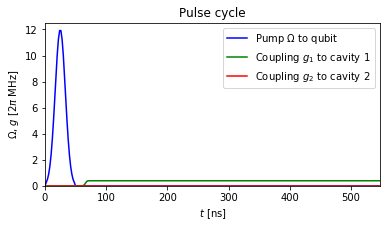

In [38]:
pump_pulse = Omega/(2*pi)*1000*pump(tlist, H_args)
sqr1_pulse = g1/(2*pi)*1000*square1(tlist, H_args)
sqr2_pulse = g2/(2*pi)*1000*square2(tlist, H_args)
plt.figure(figsize=[6,3])
plt.plot(tlist, pump_pulse, color='b', label='Pump $\\Omega$ to qubit')
plt.plot(tlist, sqr1_pulse, color='g', label='Coupling $g_1$ to cavity 1')
plt.plot(tlist, sqr2_pulse, color='r', label='Coupling $g_2$ to cavity 2')
plt.xlim([0, 547])
plt.ylim([0,12.5])
plt.xlabel("$t$ [ns]")
plt.ylabel("$\\Omega$, $g$ [$2\\pi$ MHz]")
plt.title("Pulse cycle")
plt.legend()

1710


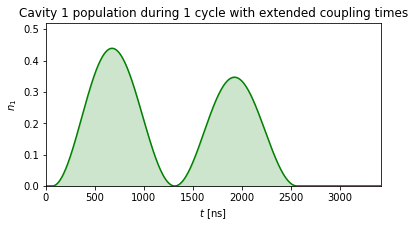

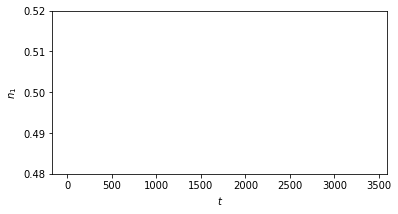

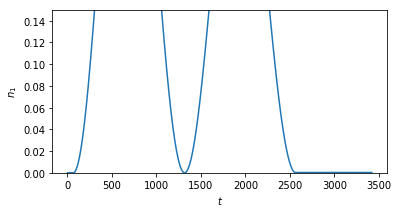

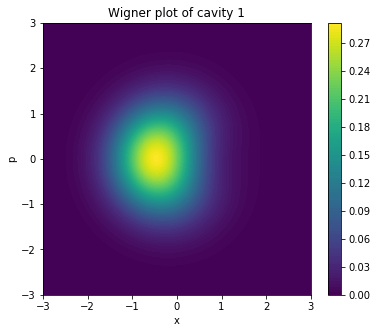

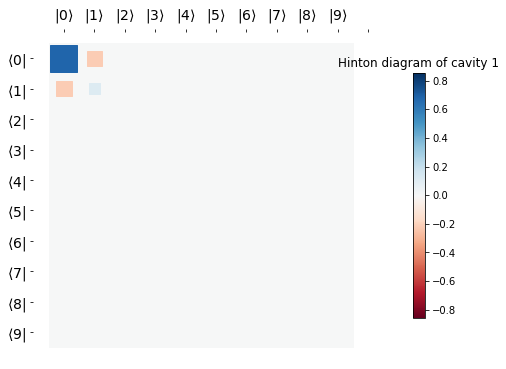

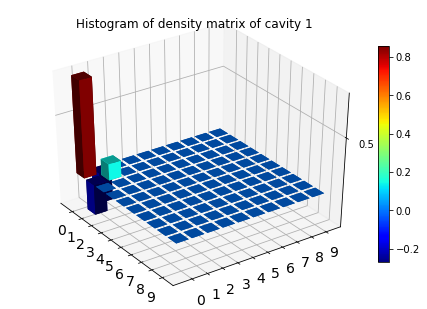

In [45]:
obj = 1    # 0 = qubit, 1 = cavity 1, 2 = cavity 2
ind = int(300/2)  # index of tlist

print(len(tlist))

plt.figure(figsize=[6,3])
plt.plot(tlist, result.expect[obj], color='g')
for i in range(N_repeat):
    plt.fill_between(tlist[int((i*t6+t0)/2):int((i*t6+t1)/2)], result.expect[obj][int((i*t6+t0)/2):int((i*t6+t1)/2)], alpha=0.2, color='b')
    plt.fill_between(tlist[int((i*t6+t2)/2):int((i*t6+t3)/2)], result.expect[obj][int((i*t6+t2)/2):int((i*t6+t3)/2)], alpha=0.2, color='g')
    plt.fill_between(tlist[int((i*t6+t4)/2):int((i*t6+t5)/2)], result.expect[obj][int((i*t6+t4)/2):int((i*t6+t5)/2)], alpha=0.2, color='r')
plt.xlim([0, 2*1710])
plt.ylim([0, 0.52])
plt.xlabel("$t$ [ns]")
plt.ylabel("$n_{}$".format(obj))
# plt.ylabel("$n_q$")
plt.title("Cavity 1 population during 1 cycle with extended coupling times")

plt.figure(figsize=[6,3])
plt.plot(tlist, result.expect[obj])
plt.xlabel("$t$")
plt.ylabel("$n_{}$".format(obj))
# plt.xlim([35,100])
plt.ylim([0.48,0.52])

plt.figure(figsize=[6,3])
plt.plot(tlist, result.expect[obj])
plt.xlabel("$t$")
plt.ylabel("$n_{}$".format(obj))
# plt.xlim([t4,t5+40])
plt.ylim([0,0.15])

cont = plots.wigner(result.states, obj=obj, ind=ind)
plots.dmat_hinton(result.states, obj=obj, ind=ind)
plots.dmat_hist(result.states, obj=obj, ind=ind)

In [40]:
from qutip.wigner import wigner as wig
def wigner_manual(rho, obj='all', ind=None, x=np.linspace(-3,3,200), y=np.linspace(-3,3,200)):
    """Plots Wigner function of specified density matrix.
    
    Parameters:
    -----------
    rho: qutip.Result.states, or qutip.qobj
         (Collection of) density matrix/matrices
    obj: int
         Index of desired object in quantum system
    ind: int
         Index of specific density matrix to plot when rho is of qutip.Result.states format
    x: list, or numpy array
       Phase space x-values to plot
    y: list, or numpy array
       Phase space y-values to plot
    """
    
    if rho == []:
        print('wigner: Give density matrix as input')
        return
        
    if (ind == None and len(rho) == 1):
        dm = rho
    else:
        dm = rho[ind]
    
    if obj != 'all':
        if not isinstance(obj, int):
            raise ValueError("Give integer value for 'obj'")
        dm = dm.ptrace(obj)
        
    W = wig(dm, x, y)
    plt.figure(figsize=([6,5]))
    cont = plt.contourf(x, y, W, 100)
    plt.xlabel('x')
    plt.ylabel('p')
    if obj == 0:
        title = "Wigner plot of qubit"
    elif (isinstance(obj, int) and obj > 0):
        title = "Wigner plot of cavity {} at $t={}$ ns".format(obj, int(2*ind))
    elif obj == 'all':
        title = "Wigner plot of total system"
    plt.title(title)
    plt.colorbar()
    plt.show()
    return cont

In [41]:
def dmat_hinton_manual(rho, obj='all', ind=None):
    """Plots Hinton diagram of specified density matrix.
    
    Parameters:
    -----------
    rho: qutip.Result.states
         density matrices per time instant
    obj: int
         Index of desired object in quantum system
    ind: int
         Index of specific density matrix to plot when rho is of qutip.Result.states format
    
    Remark:
    -------
    Title is not set in correct place.
    """
    
    if isinstance(rho, list):
        dm = rho[ind]
    else:
        dm = rho
    
    if obj != 'all':
        if not isinstance(obj, int):
            raise ValueError("Give integer value for 'obj'")
        dm = dm.ptrace(obj)
    
    # TODO: Show title in correct location above the diagram
    if obj == 0:
        title = "Hinton diagram of qubit"
    elif (isinstance(obj, int) and obj > 0):
        title = "Hinton diagram of cavity {} at $t={}$ ns".format(obj, int(2*ind))
    elif obj == 'all':
        title = "Hinton diagram of total system"
    
    fig, ax = hinton(dm, title=title)
    plt.title(title)

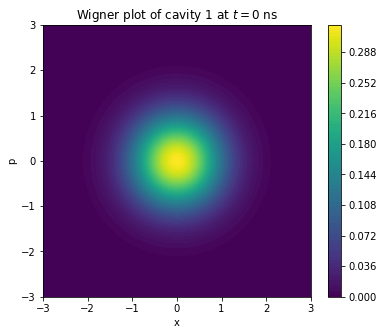

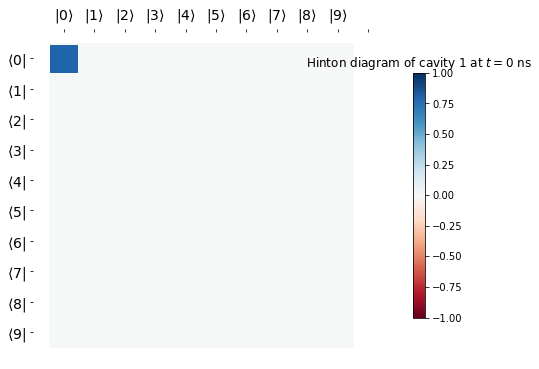

In [42]:
obj = 1    # 0 = qubit, 1 = cavity 1, 2 = cavity 2
ind = int(0/2)  # index of tlist
cont = wigner_manual(result.states, obj=obj, ind=ind)
dmat_hinton_manual(result.states, obj=obj, ind=ind)

Text(0.5,1,'Cavity 1 population during 1 cycle with extended coupling times')

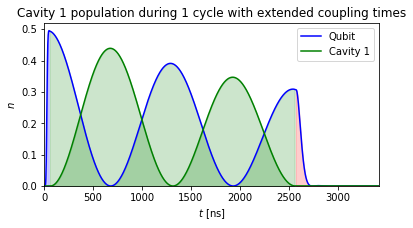

In [49]:
plt.figure(figsize=[6,3])
plt.plot(tlist, result.expect[0], color='b', label='Qubit')
for i in range(N_repeat):
    plt.fill_between(tlist[int((i*t6+t0)/2):int((i*t6+t1)/2)], result.expect[0][int((i*t6+t0)/2):int((i*t6+t1)/2)], alpha=0.2, color='b')
    plt.fill_between(tlist[int((i*t6+t2)/2):int((i*t6+t3)/2)], result.expect[0][int((i*t6+t2)/2):int((i*t6+t3)/2)], alpha=0.2, color='g')
    plt.fill_between(tlist[int((i*t6+t4)/2):int((i*t6+t5)/2)], result.expect[0][int((i*t6+t4)/2):int((i*t6+t5)/2)], alpha=0.2, color='r')
plt.plot(tlist, result.expect[1], color='g', label='Cavity 1')
for i in range(N_repeat):
    plt.fill_between(tlist[int((i*t6+t0)/2):int((i*t6+t1)/2)], result.expect[1][int((i*t6+t0)/2):int((i*t6+t1)/2)], alpha=0.2, color='b')
    plt.fill_between(tlist[int((i*t6+t2)/2):int((i*t6+t3)/2)], result.expect[1][int((i*t6+t2)/2):int((i*t6+t3)/2)], alpha=0.2, color='g')
    plt.fill_between(tlist[int((i*t6+t4)/2):int((i*t6+t5)/2)], result.expect[1][int((i*t6+t4)/2):int((i*t6+t5)/2)], alpha=0.2, color='r')
plt.xlim([0, 2*1710])
plt.ylim([0, 0.52])
plt.xlabel("$t$ [ns]")
# plt.ylabel("$n_{}$".format(obj))
plt.ylabel("$n$")
plt.legend()
plt.title("Cavity 1 population during 1 cycle with extended coupling times")